<br><br><center><h1 style="font-size:31px;color:#20B2AA">ĐỒ ÁN TỐT NGHIỆP</h1></center>
<br><br><center><h1 style="font-size:31px;color:#20B2AA">Chuẩn đoán bệnh ung thư phổi sử dụng Machine Learning</h1></center>
<br>
<table>
<col width="750">
<col width="450">
<tr>
<td><img src="https://hellobacsi.com/wp-content/uploads/2017/08/Untitled-design-32.jpg" align="middle" style="width:650px;height:360px;"/></td>
<td>
   <center style="font-size:2em;color:#DC143C"> <h4 > Trịnh Đình Phúc </h4></center>
    <p align="justify" style="font-size:12px;color:#2F4F4F;">Với sự bùng nổ của thời đại công nghệ thông tin như hiện nay thì việc bùng nổ dữ liệu cũng tăng theo. Dữ liệu chính là tài nguyên quý giá. Việc đưa ra các công cụ khai thác hiệu quả trên khối lượng lớn dữ liệu ấy nhằm rút trích các tri thức phục vụ cho nhu cầu sử dụng của con người là vô cùng cấp thiết. 
        <br>
        Chính vì thế em đã chọn đề tài “TÌM HIỂU VÀ VẬN DỤNG PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU LỚN” nhằm áp dụng quy trình xử lý dữ liệu vào thực tiễn, rút trích tri thức từ dữ liệu.
        <br>
        Để mô tả cho quá trình xử lý dữ liệu và rút trích tri thức, em xin chọn dữ liệu của <a href="https://data.mendeley.com/datasets/rscbjbr9sj/2">Mendeley </a> (là một nhà quản lý tài liệu tham khảo miễn phí và mạng xã hội học thuật có thể giúp tổ chức nghiên cứu, cộng tác với những người khác trực tuyến và khám phá nghiên cứu mới nhất ).  Bài toán là dựa vào ảnh chụp cắt lớp quang học có gắn nhãn (OCT) và ảnh ngực chụp bằng X-quang dự đoán bệnh nhân có bị ung thư phổi hay không sử dụng Machine Learning.

    </p>
</td>
</tr>
</table>

![](https://image.ibb.co/bUvuRd/download.png)
### <p style="color:#00008B">Nhìn kỹ, thì có một số trường hợp ta sẽ không thể phân biệt giữa trường hợp "bình thường" và trường hợp "viêm phổi" bằng mắt thường. </p>
![](https://image.ibb.co/iGCDnJ/diagnosing.png)
###  Nếu chúng ta có thể xây dựng một trình phân loại mạnh mẽ, nó sẽ là một trợ giúp tuyệt vời cho bác sĩ.


-----------------------------------------------

In [1]:
import os
import glob
import h5py
import shutil
import random
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
import urllib
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.models import model_from_yaml
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

print(os.listdir("../input"))

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['chest-xray-pneumonia', 'vgg16']


In [2]:
import tensorflow as tf

# khởi tạo môi trường dựa trên hàm băm trong python
os.environ['PYTHONHASHSEED'] = '0'

# đặt giá trị seed
np.random.seed(111)

# vô hiệu hoóa multi-threading (đa luồng) trong tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# đặt giá trị random seed
tf.set_random_seed(111)

# Định nghĩa một tensorflow session với tùy chỉnh session như trên
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# đặt session trong keras
K.set_session(sess)

aug.seed(111) # Make the augmentation sequence deterministic

### Tập dữ liệu được chia thành 3 bộ: 
*  Bộ huấn luyện (training data)  5216 ảnh.
*  Bộ xác thực (validation data) 624 ảnh. 
*  Bộ kiểm tra (test data) 16 ảnh.
![](https://image.ibb.co/khr67J/folderhychiarec.png)

In [3]:
# Định nghĩa đường dẫn đến thư mục dữ liệu
data_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')

train_dir = data_dir / 'train'

val_dir = data_dir / 'val'

test_dir = data_dir / 'test'

Đầu tiên ta sẽ đi qua bộ dữ liệu huấn luyện. Chúng ta sẽ làm một số phân tích, xem xét một số mẫu, kiểm tra số lượng mẫu cho mỗi lớp.

Mỗi thư mục trên chứa hai thư mục con:
* `NORMAL`: Đây là những mẫu mô tả trường hợp bình thường (không viêm phổi).
* `PNEUMONIA`: Thư mục này chứa các mẫu đó là các trường hợp viêm phổi.

In [4]:
# Lấy đường dẫn đến các thư mục con NORMAL và PNEUMONIA(viêm phổi)
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# lấy hình ảnh
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

#tạo một mảng rỗng để chứa hình ảnh
train_data = []

# Quét toàn bộ dữ liệu normal, và gán nhãn bằng 0
for img in normal_cases:
    train_data.append((img,0))

# Quét toàn bộ dữ liệu PNEUMONIA(viêm phổi) và gán nhãn bằng 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Bỏ dữ liệu vào dataframe
train_data = pd.DataFrame(train_data, columns=['Đường dẫn hình ảnh', 'label (nhãn)'],index=None)

# Trộn dữ liệu
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Xem dữ liệu
train_data.head(10)

,Đường dẫn hình ảnh,label (nhãn)
0,../input/chest-xray-pneumonia/chest_xray/chest...,0
1,../input/chest-xray-pneumonia/chest_xray/chest...,0
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,1
5,../input/chest-xray-pneumonia/chest_xray/chest...,0
6,../input/chest-xray-pneumonia/chest_xray/chest...,1
7,../input/chest-xray-pneumonia/chest_xray/chest...,0
8,../input/chest-xray-pneumonia/chest_xray/chest...,0
9,../input/chest-xray-pneumonia/chest_xray/chest...,1


### Có bao nhiêu mẫu cho mỗi lớp trong tập dữ liệu?

1    3875
0    1341
Name: label (nhãn), dtype: int64


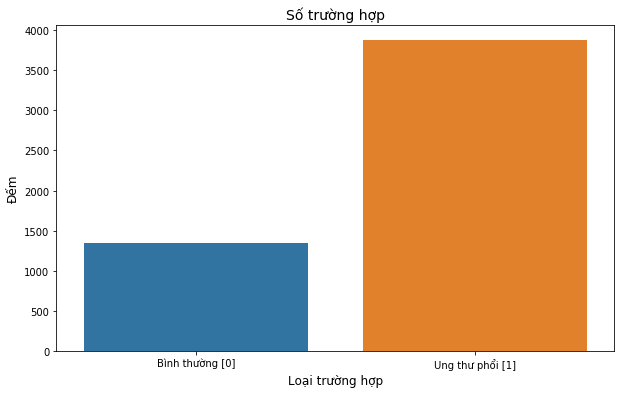

In [5]:
# Đếm số mẫu cho mỗi lớp
cases_count = train_data['label (nhãn)'].value_counts()
print(cases_count)

# Plot kết quả
plt.figure(figsize=(10,6))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Số trường hợp', fontsize=14)
plt.xlabel('Loại trường hợp', fontsize=12)
plt.ylabel('Đếm', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Bình thường [0]', 'Ung thư phổi [1]'])
plt.show()

Ta có thể thấy dữ liệu bị mất cân bằng cao (class imbalance). Ta thấy, các trường hợp viêm phổi nhiều gấp ba lần so với các trường hợp bình thường. Tình trạng này là rất bình thường khi nói đến dữ liệu y tế. Dữ liệu sẽ luôn mất cân đối. hoặc sẽ có quá nhiều trường hợp bình thường hoặc sẽ có quá nhiều trường hợp mắc bệnh.

Hãy xem xét trường hợp bình thường khác với trường hợp viêm phổi. Chúng tôi sẽ xem xét các mẫu somes từ chính dữ liệu đào tạo của chúng tôi.

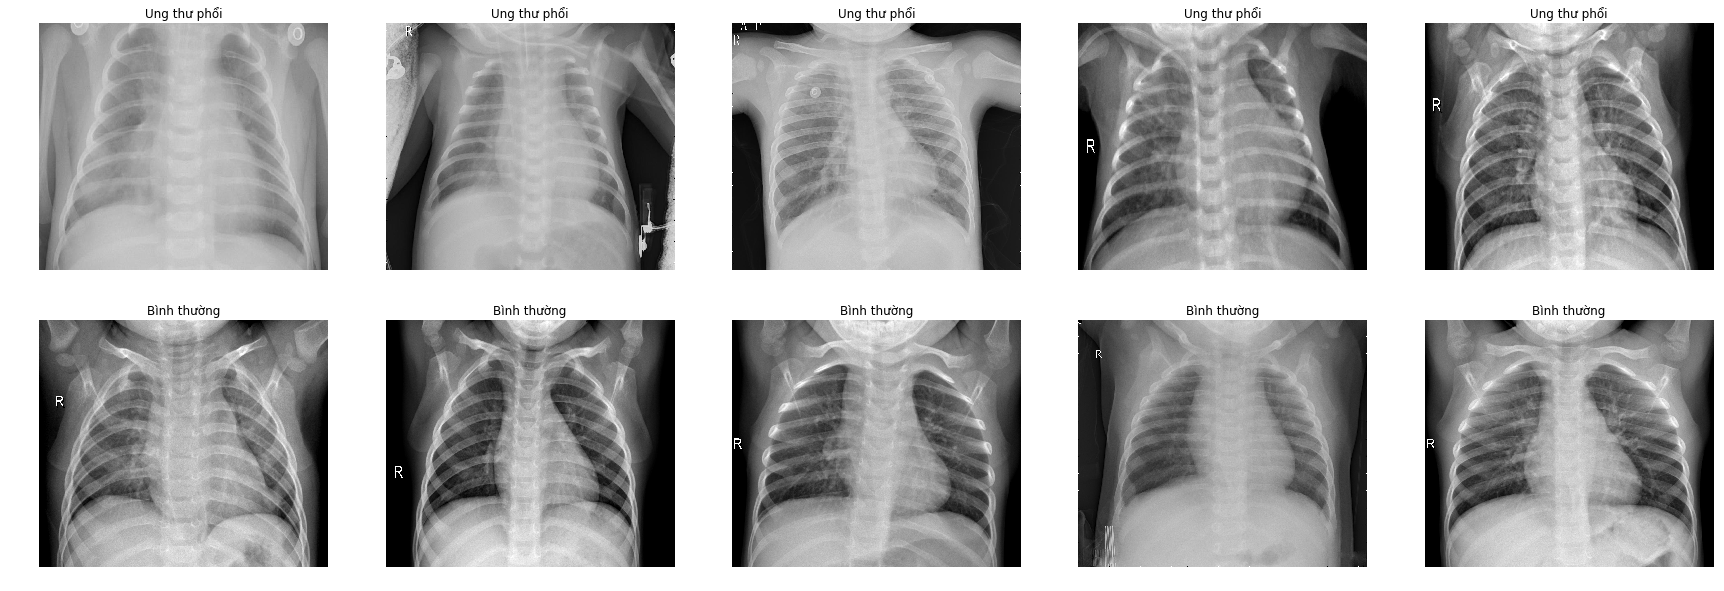

Kích cỡ của 1 ảnh: (736, 1048)


In [6]:
# Lấy 1 vài mẫu của cả 2 trường hợp
pneumonia_samples = (train_data[train_data['label (nhãn)']==1]['Đường dẫn hình ảnh'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label (nhãn)']==0]['Đường dẫn hình ảnh'].iloc[:5]).tolist()

# gộp dữ liệu thành 1 mảng và xóa 2 mảng cũ
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot dữ liệu 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Ung thư phổi")
    else:
        ax[i//5, i%5].set_title("Bình thường")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()
print("Kích cỡ của 1 ảnh: {0}".format( imread(samples[1]).shape))

# (Bên trái) - Bình thường | (Bên phải) - Ung thư phổi
![](https://image.ibb.co/ifaqGd/2.png)
<center>Hình 1 </center>
![](https://image.ibb.co/nhwVGd/3.png)
<center>Hình 2 </center>
![](https://image.ibb.co/mdpHwd/1.png)
<center>Hình 3 </center>

Nếu bạn nhìn kỹ, thì có một số trường hợp bạn sẽ không thể phân biệt giữa trường hợp bình thường và trường hợp viêm phổi bằng mắt thường.  Nếu chúng ta có thể xây dựng một trình phân loại mạnh mẽ, nó sẽ là một trợ giúp tuyệt vời cho bác sĩ.

### Chuẩn bị dữ liệu xác thực

In [7]:
# Lấy đường dẫn sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Lấy mảng của toàn bộ ảnh
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Tạo 2 mảng rỗng để chứa hình ảnh validation và nhãn của nó
valid_data = []
valid_labels = []

# Một số hình ảnh có màu xám trong khi phần lớn trong số đó chứa 3 kênh. Vì vậy, nếu hình ảnh là thang độ xám, chúng tôi sẽ chuyển đổi thành hình ảnh có 3 kênh.
# Chúng ta sẽ chuẩn hóa các giá trị pixel và thay đổi kích thước tất cả hình ảnh thành 224x224
# trường hợp Normal 
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# trường hợp Pneumonia        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

# Chuyển dữ liệu mảng thành mảng trong numpy
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Tổng số mẫu kiểm định: ", valid_data.shape)
print("Tổng số nhãn:", valid_labels.shape)

Tổng số mẫu kiểm định:  (16, 224, 224, 3)
Tổng số nhãn: (16, 2)


## Augmentation (tăng cường ảnh) 
Tăng cường dữ liệu là một kỹ thuật mạnh mẽ giúp trong hầu hết mọi trường hợp để cải thiện độ mạnh của mô hình Machine Learning. Nhưng tăng cường có thể hữu ích hơn nhiều khi tập dữ liệu bị mất cân bằng. Ta có thể tạo các mẫu khác nhau của lớp chưa được lấy mẫu để cố gắng cân bằng phân phối tổng thể.
![](https://cdn-images-1.medium.com/max/800/1*dJNlEc7yf93K4pjRJL55PA.png)

In [8]:
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips (lật ảnh theo chiều ngang)
    iaa.Affine(rotate=20), # quay hình ảnh
    iaa.Multiply((1.2, 1.5))]) #random cho sáng cường độ ảnh

### Tạo dữ liệu training

In [9]:
def data_gen(data, batch_size):
    # lấy tổng số mẫu trong dữ liệu
    n = len(data)
    steps = n//batch_size

    # Định nghĩa 2 mảng để chưa batch data và labels (nhãn)
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # tạo một mảng numpy với n độ dài
    indices = np.arange(n)

    # khởi tạo bộ đếm
    i =0
    while True:
        np.random.shuffle(indices)
        # lấy batch tiếp theo
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['Đường dẫn hình ảnh']
            label = data.iloc[idx]['label (nhãn)']
    
            # sử dụng one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # đọc ảnh và resize ảnh
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
    
            # kiểm tra xem có phải là ảnh gray hay không
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
    
            # chuyển về dạng BGR
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # chuẩn hóa ảnh
            orig_img = img.astype(np.float32)/255.
    
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
    
            # sử dụng augment để tạo thêm ảnh
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
        i+=1
        yield batch_data, batch_labels
        if i>=steps:
            i=0

## Modeling (sử dụng mạng Convolutional Neural  Network)
### Áp dụng mạng Inception-v3 của Google phát triển năm 2014
![](https://i2.wp.com/sefiks.com/wp-content/uploads/2017/12/imagenet-models.png?ssl=1)
![](https://www.mathworks.com/content/mathworks/www/en/solutions/deep-learning/convolutional-neural-network/jcr:content/mainParsys/band_copy_copy_14735_1026954091/mainParsys/columns_1606542234_c/2/image.adapt.full.high.jpg/1530247928116.jpg)


In [10]:
#khởi tạo mạng
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [11]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

# # 10 lớp convolution, 3 Lớp Fully-connected, 4 lớp Maxpooling, 4 lớp Batchnormalization 2 lớp dropout

# Giải thích chức năng mỗi lớp
##### Convolution (tích chập)
![](https://camo.githubusercontent.com/3309220c48ab22c9a5dfe7656c3f1639b6b1755d/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f6e3134713930677a386138726278622f32645f636f6e766f6c7574696f6e2e706e673f7261773d31)
##### ReLu
Bất cứ nơi nào có số âm, hoán đổi nó với 0. Điều này giúp CNN giữ vững sự tin cậy toán học bằng cách giữ các giá trị đã được học khỏi bị mắc kẹt gần 0 hoặc bị thổi bay về vô tận
![](https://image.slidesharecdn.com/deeplearning-170828064322/95/deep-learning-71-638.jpg?cb=1503924448)
##### Dropout
![](https://www.researchgate.net/profile/Giorgio_Roffo/publication/317277576/figure/fig23/AS:500357438869504@1496305917227/9-An-illustration-of-the-dropout-mechanism-within-the-proposed-CNN-a-Shows-a.png)

In [12]:
print(model.layers[0],"\n",model.layers[1],"\n",model.layers[2],"\n",model.layers[3],"\n",model.layers[4])

In [13]:
# sử dụng trọng số VGG16
f = h5py.File('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Chọn số lớp muốn thiết lập các trọng số như trên

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

# Cấu hình phần cứng:
## 32GB RAM
![](https://hanoicomputercdn.com/media/news/1195_ecc_reg_ram.jpg)
## GPU 24GB K80 - TESLA
![](https://image.ibb.co/mHu448/k80.png)
## Với 104,197,506 tham số thì tổng thời gian train hết: 4 tiếng 36 phút 

In [14]:
#sử dụng hàm tối ưu Adam với learning rate là 0.00001 và tốc độ phân rã học tập trên mỗi lần cập nhật 
opt = Adam(lr=0.0001, decay=1e-5) 
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [15]:
batch_size = 16 #khởi tạo batch size và epochs
nb_epochs = 20

# Lấy dữ liệu train generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Định nghĩa số lần training
nb_train_steps = train_data.shape[0]//batch_size

print("Tổng sỐ lần training là: {0} và độ dài của validation data là: {1}".format(nb_train_steps, len(valid_data)))

Tổng sỐ lần training là: 326 và độ dài của validation data là: 16


In [16]:
# Bắt đầu training model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],class_weight={0:1, 1:0.4})

Epoch 1/20
326/326 [==============================] - 209s 642ms/step - loss: 0.2379 - acc: 0.7644 - val_loss: 0.4819 - val_acc: 0.7500
Epoch 2/20
326/326 [==============================] - 202s 618ms/step - loss: 0.0979 - acc: 0.9475 - val_loss: 0.4775 - val_acc: 0.7500
Epoch 3/20
326/326 [==============================] - 201s 618ms/step - loss: 0.0816 - acc: 0.9555 - val_loss: 0.3422 - val_acc: 0.8125
Epoch 4/20
326/326 [==============================] - 201s 617ms/step - loss: 0.0683 - acc: 0.9626 - val_loss: 0.2607 - val_acc: 0.8750
Epoch 5/20
326/326 [==============================] - 201s 617ms/step - loss: 0.0577 - acc: 0.9709 - val_loss: 0.0851 - val_acc: 0.9375
Epoch 6/20
326/326 [==============================] - 201s 617ms/step - loss: 0.0638 - acc: 0.9695 - val_loss: 0.1526 - val_acc: 0.9375
Epoch 7/20
326/326 [==============================] - 201s 617ms/step - loss: 0.0674 - acc: 0.9640 - val_loss: 0.2524 - val_acc: 0.9375
Epoch 8/20
326/326 [============================

## Đánh giá mô hình (Data Evaluation)

In [17]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("basic_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("basic_model.h5")
print("Lưu model")

Lưu model


In [18]:
# load YAML and create model
yaml_file = open('basic_model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("basic_model.h5")

print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


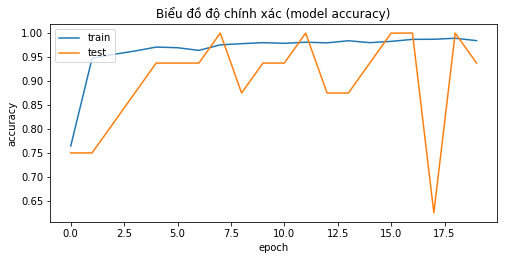

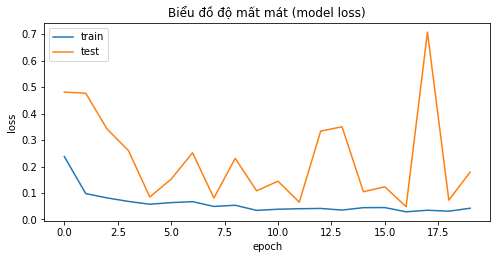

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Biểu đồ độ chính xác (model accuracy)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(8, 8))
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Biểu đồ độ mất mát (model loss)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# chuẩn bị dữ liệu test
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Tổng số mẫu test là: ", test_data.shape)
print("Tổng số nhãn là:", test_labels.shape)

Tổng số mẫu test là:  (624, 224, 224, 3)
Tổng số nhãn là: (624, 2)


In [21]:
# Đánh giá model
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Độ mất mát trên tập test: ", test_loss)
print("Độ chính xác trên tập test: ", test_score)

624/624 [==============================] - 6s 9ms/step
Độ mất mát trên tập test:  0.9251360054476768
Độ chính xác trên tập test:  0.8509615384615384


In [22]:
# thực hiện dự đoán sau khi train mô hình
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)
orig_test_labels = np.argmax(test_labels, axis=-1)

In [23]:
print("tổng số ảnh test là:{}".format(orig_test_labels.shape[0]))

tổng số ảnh test là:624


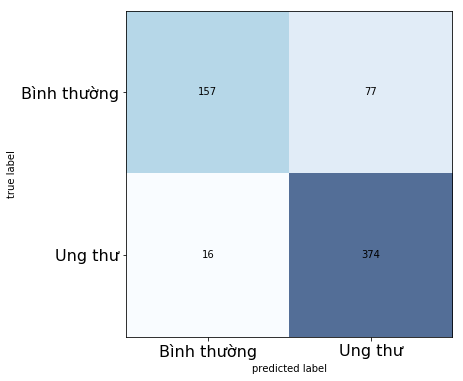

In [24]:
# Thực hiện confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,6), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Bình thường', 'Ung thư'], fontsize=16)
plt.yticks(range(2), ['Bình thường', 'Ung thư'], fontsize=16)
plt.show()

## Trong 624 ảnh test, có 234 ảnh là ảnh X-quang bệnh nhân bình thường, 390 ảnh là ảnh X-quang của bệnh nhân ung thư phổi. 
### Cụ thể:
#### Trong 234 ảnh X-quang bệnh nhân bình thường, thì mạng nơ ron đoán đúng 91 ảnh, và 143 ảnh đoán sai.
#### Trong 390 ảnh X-quang bệnh nhân  ung thư phổi, thì mạng nơ ron đoán đúng 388  ảnh, và 2 ảnh đoán sai.

In [25]:
Y_pred = np.argmax(model.predict(test_data, batch_size = 128), axis=1)
print(classification_report(orig_test_labels,Y_pred))

             precision    recall  f1-score   support

          0       0.91      0.67      0.77       234
          1       0.83      0.96      0.89       390

avg / total       0.86      0.85      0.85       624



# Dự đoán ảnh sau khi model được huấn luyện

In [26]:
# tính Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall của model {:.2f}".format(recall))
print("Precision của model là {:.2f}".format(precision))

Recall của model 0.96
Precision của model là 0.83


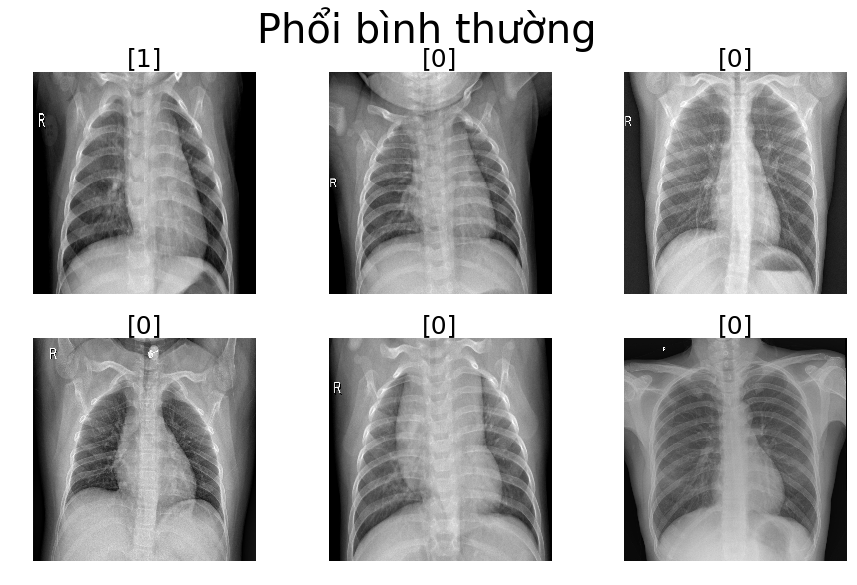

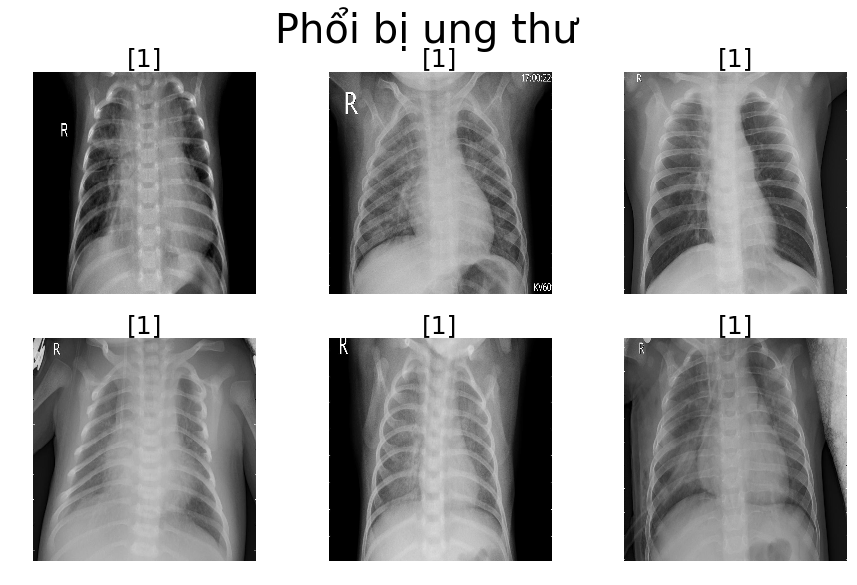

In [34]:
total_images_train_normal = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/')
total_images_train_pneumonia = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/')

sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    img = cv2.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/'+sample_normal[i])
    img = cv2.resize(img, (224,224))
    ax[i//3,i%3].imshow(img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img = img.reshape(1,224, 224, 3)
    y_proba = model.predict(img)
    y_classes = y_proba.argmax(axis=-1)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].set_title(str(y_classes),fontsize=25)
f.suptitle('Phổi bình thường',fontsize=40)
plt.show()

sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    img = cv2.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/'+sample_pneumonia[i])
    img = cv2.resize(img, (224,224))
    ax[i//3,i%3].imshow(img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img = img.reshape(1,224, 224, 3)
    y_proba = model.predict(img)
    y_classes = y_proba.argmax(axis=-1)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].set_title(str(y_classes),fontsize=25)
f.suptitle('Phổi bị ung thư',fontsize=40)
plt.show()